In [33]:
import numpy as np
import sys,os
module_root = '..'
sys.path.append(module_root)
from settings import raw_folder, train_folder, intermediate_folder
import glob
import seaborn as sns
import SimpleITK as sitk
import pandas as pd

In [2]:
tifs = sorted(glob.glob(raw_folder + '/*.tif'))
print('no of tifs: {}'.format(len(tifs)))

no of tifs: 1


In [3]:
image_index = 0
tif_path = tifs[image_index]
image = sitk.ReadImage(tif_path)
nda = sitk.GetArrayFromImage(image)

In [4]:
labels = sorted(glob.glob(raw_folder + '/' + os.path.basename(tif_path).split('.')[0] + '_label_*.nrrd'))
print('no of labels: {}'.format(len(labels)))

no of labels: 1


In [9]:
label_index = 0
label_path = labels[label_index]
label = sitk.ReadImage(label_path)
label_nda = sitk.GetArrayFromImage(label).squeeze()
label_mask = np.ma.masked_where(label_nda== 0, label_nda)

In [10]:
print(label_path)
roi_path = label_path.replace('.nrrd', '_roi.acsv')

/home/mehrtash/dropbox/qanat/raw/DS1039-2088DA038_b_label_1.nrrd


In [11]:
roi = np.zeros((2,2))
i = 0
with open(roi_path) as f:
    for line in f.readlines():
        if line.startswith('point'):
            p = line.split('|')
            roi[i,0] = -float(p[1])
            roi[i,1] = -float(p[2])
            i += 1

In [12]:
center = list(roi[0])
center = np.asarray(image.TransformPhysicalPointToIndex(center))
spacing = image.GetSpacing()
length = np.abs(roi[1]/spacing).astype(np.int)
start = center - length
end = center + length
print(start,end)

[19164  2117] [21168  4121]


In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

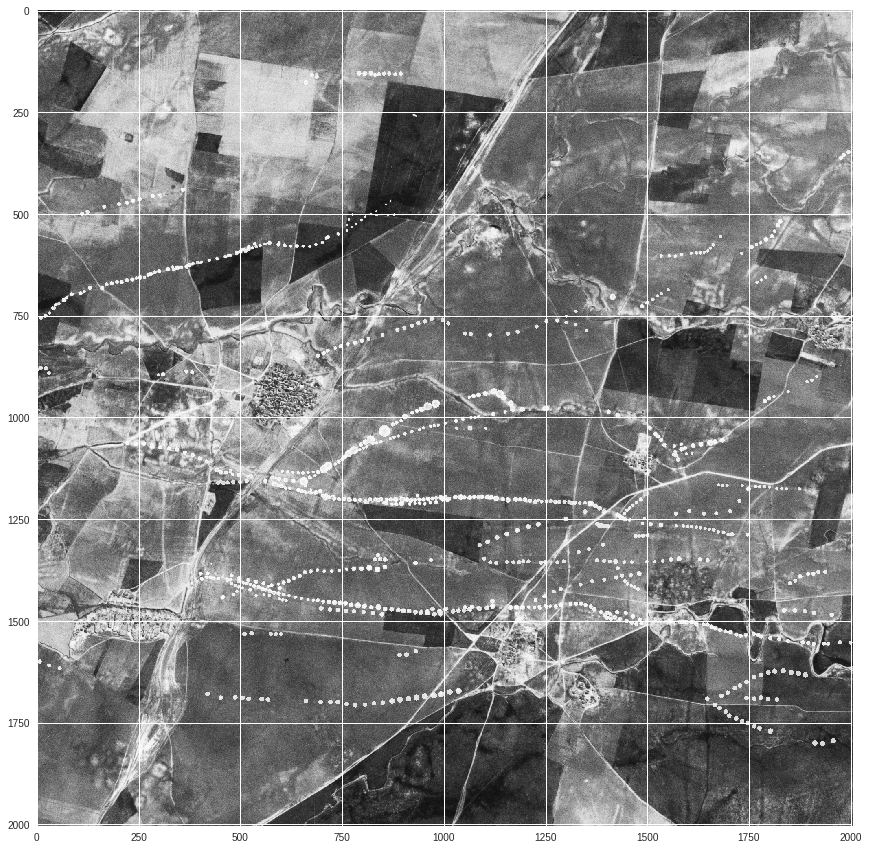

In [14]:
plt.figure(figsize=(15,15))
plt.imshow(nda[start[1]:end[1], start[0]:end[0]], cmap=plt.cm.gray)
plt.imshow(label_mask[start[1]:end[1], start[0]:end[0]], alpha=0.8)

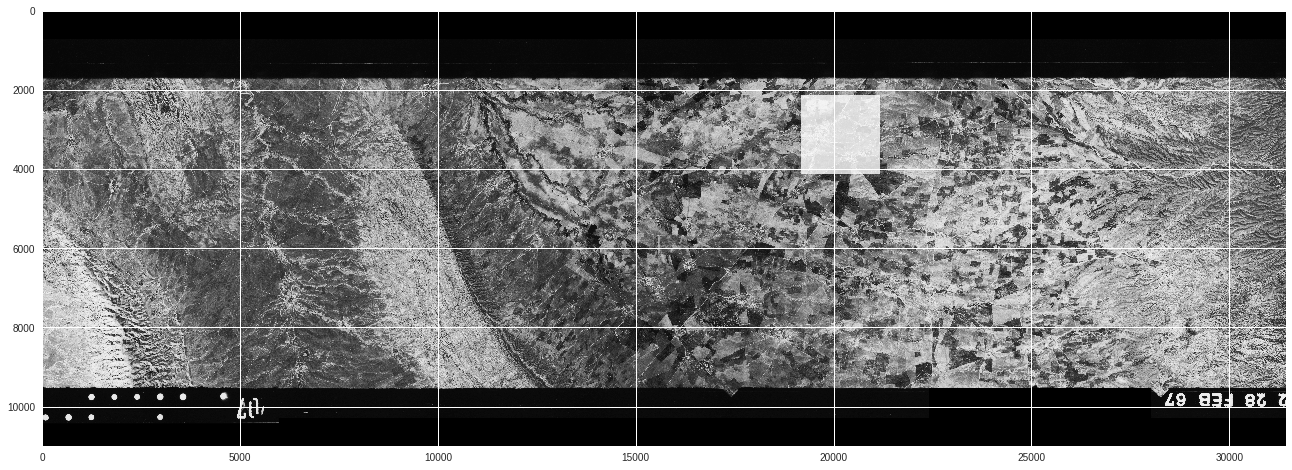

In [15]:
plt.figure(figsize=(24,8))
annotation_area = np.zeros_like(nda)
annotation_area[start[1]:end[1], start[0]:end[0]] = 255
annotation_area = np.ma.masked_where(annotation_area== 0, annotation_area)
plt.imshow(nda, cmap=plt.cm.gray)
plt.imshow(annotation_area, alpha=0.8)

In [16]:
ccf = sitk.ConnectedComponentImageFilter()
ccf.SetFullyConnected(True)
ccf_labelmap = ccf.Execute(label)
stats_filter = sitk.LabelStatisticsImageFilter()
stats_filter.Execute(ccf_labelmap, ccf_labelmap)
labels = list(stats_filter.GetLabels())
labels.remove(0)
print(len(labels))

619


In [17]:
changeFilter = sitk.ChangeLabelImageFilter()
changeMap = sitk.DoubleDoubleMap()
for label_val in labels:
    changeMap[label_val] = int(np.random.randint(0,255,1)[0])
ccf_labelmap_random = changeFilter.Execute(ccf_labelmap, changeMap)

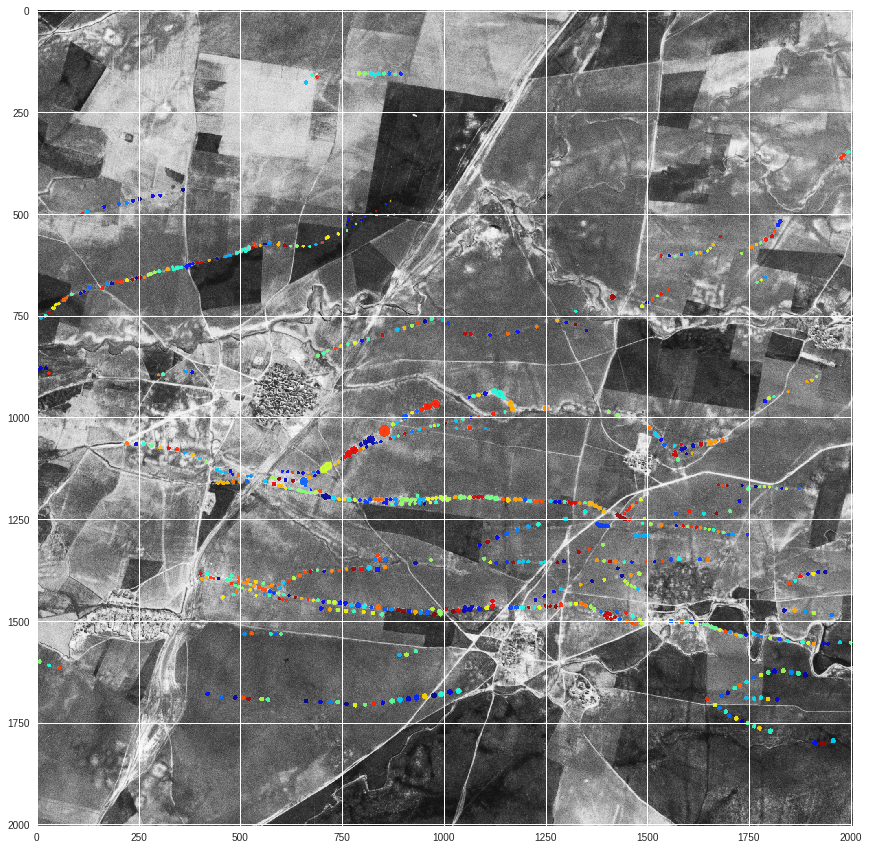

In [18]:
plt.figure(figsize=(15,15))
label_nda = sitk.GetArrayFromImage(ccf_labelmap_random).squeeze()
label_mask = np.ma.masked_where(label_nda== 0, label_nda)
plt.imshow(nda[start[1]:end[1], start[0]:end[0]], cmap=plt.cm.gray)
plt.imshow(label_mask[start[1]:end[1], start[0]:end[0]], alpha=0.9,cmap=plt.cm.jet)

In [19]:
d = []
pd.DataFrame(d)
for label_value in labels:
    bb = np.asarray(stats_filter.GetBoundingBox(label_value))
    d.append({'label': label_value, 'count': stats_filter.GetCount(label_value), 'x': int( bb[0] + (bb[1]-bb[0])/2), 
              'y': int(bb[2] + (bb[3]-bb[2])/2)}) 

In [20]:
df = pd.DataFrame(d)

In [21]:
largest = df.sort_values('count', ascending=False).head(25)
smallest = df.sort_values('count', ascending=True).head(25)
largest

count  label      x     y
618   3028    619   5079  4846
160    786    161  20127  3089
213    665    214  19930  3206
183    645    184  20017  3150
194    628    195  19973  3177
284    623    285  20075  3323
151    608    152  20298  3060
227    566    228  19873  3240
515    456    516  20571  3604
56     405     57  19668  2705
309    380    310  20534  3334
280    364    281  20165  3316
330    357    331  20552  3381
245    351    246  19818  3276
480    348    481  20221  3587
281    333    282  20280  3315
161    330    162  20329  3089
532    314    533  20815  3630
351    309    352  20648  3407
283    304    284  20133  3319
325    302    326  20598  3361
270    297    271  19820  3298
249    277    250  19620  3276
274    277    275  19873  3312
292    264    293  20024  3323

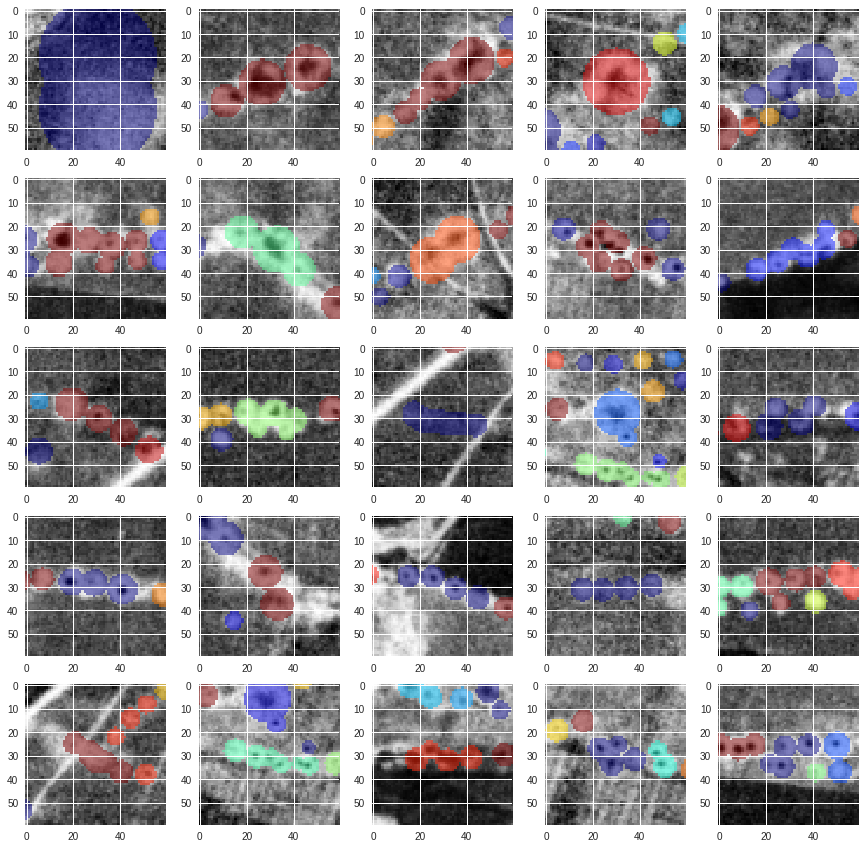

In [22]:
fig, axs = plt.subplots(5,5, figsize=(15, 15), facecolor='w', edgecolor='k')
pad = 30
axs = axs.ravel()
i = 0
for index, row in largest.iterrows():
    x = row['x']
    y = row['y']
    label_val = row['label']
    axs[i].imshow(nda[-pad+y:pad+y, -pad+x:pad+x], cmap=plt.cm.gray)
    axs[i].imshow(label_mask[-pad+y:pad+y, -pad+x:pad+x], alpha=0.5, cmap=plt.cm.jet)
    i +=1

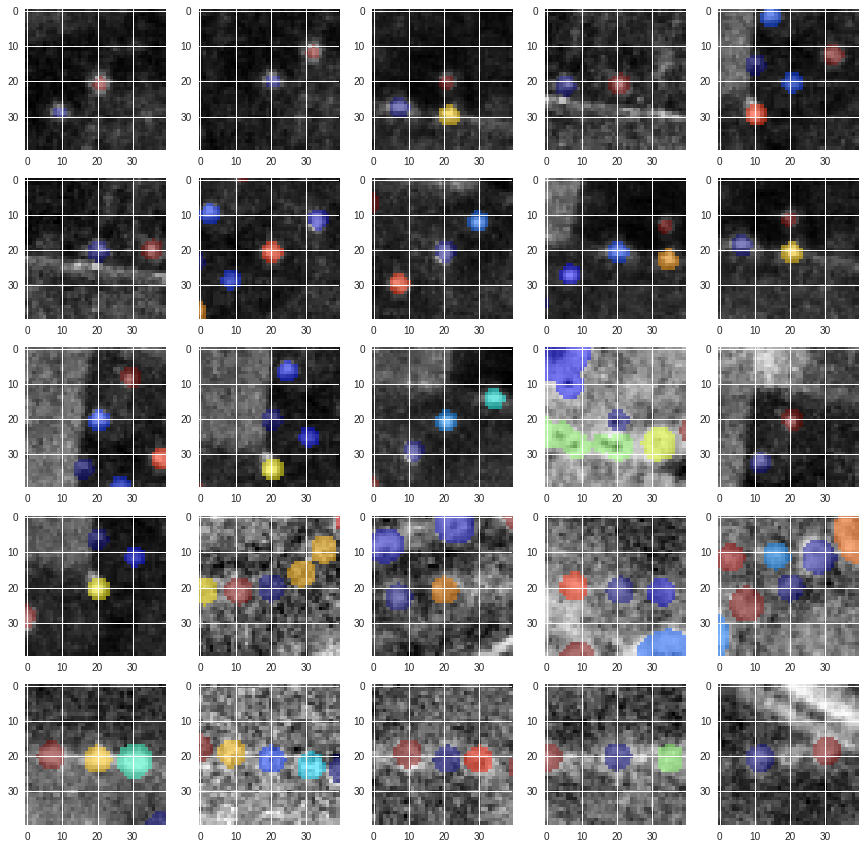

In [23]:
fig, axs = plt.subplots(5,5, figsize=(15, 15), facecolor='w', edgecolor='k')
pad = 20
axs = axs.ravel()
i = 0
for index, row in smallest.iterrows():
    x = row['x']
    y = row['y']
    label_val = row['label']
    axs[i].imshow(nda[-pad+y:pad+y, -pad+x:pad+x], cmap=plt.cm.gray)
    axs[i].imshow(label_mask[-pad+y:pad+y, -pad+x:pad+x], alpha=0.5, cmap=plt.cm.jet)
    i +=1

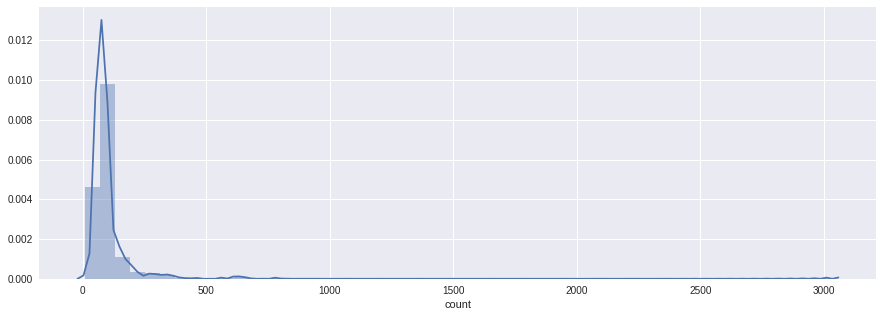

In [24]:
tmp_df = df[df.label != 618] # this is based on random ...
plt.figure(figsize=(15, 5))
sns.distplot(tmp_df['count'])

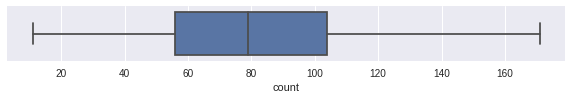

In [25]:
plt.figure(figsize=(10, 1))
sns.boxplot(df['count'],showfliers=False)

In [29]:
pred_path = os.path.join(train_folder, '2017_09_21_19_08_34', 'test_predictions', 'pilot_reconstructed.npy')

In [30]:
pred = np.load(pred_path)

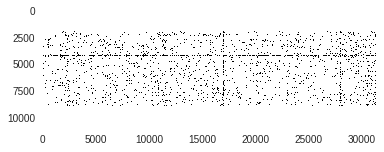

In [32]:
plt.imshow(pred)
plt.show()

In [37]:
pred_image =sitk.GetImageFromArray(pred) 
pred_image.CopyInformation(image)
sitk.WriteImage(pred_image , os.path.join(intermediate_folder, 'goh.nrrd'))